In [98]:
import pandas as pd
import numpy as np
import random
import string
from datetime import datetime, timedelta

import pyspark.sql.functions as  F
from pyspark.sql.functions import coalesce, lit, rand, when, col
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegressionModel, RandomForestClassificationModel
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import GBTClassificationModel

import shap

In [2]:
packages = [
    'org.apache.hadoop:hadoop-aws:3.3.4',
    'org.apache.hadoop:hadoop-client-api:3.3.4',
    'org.apache.hadoop:hadoop-client-runtime:3.3.4',
]

conf = SparkConf() \
    .setAppName("MyApp") \
    .set("spark.driver.memory", "8g") \
    .set("spark.executor.memory", "8g") \
    .set('spark.jars.packages', ','.join(packages))

sc = SparkContext(conf=conf)

hadoop_config = sc._jsc.hadoopConfiguration()
hadoop_config.set('fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
hadoop_config.set('com.amazonaws.services.s3.enableV4', 'true')

spark = SparkSession(sc)

24/07/23 19:09:41 WARN Utils: Your hostname, thamaMBP.local resolves to a loopback address: 127.0.0.1; using 172.20.10.5 instead (on interface en0)
24/07/23 19:09:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/thama/.ivy2/cache
The jars for the packages stored in: /Users/thama/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.hadoop#hadoop-client-api added as a dependency
org.apache.hadoop#hadoop-client-runtime added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3f180236-ad4f-4bd7-ad18-d7793395de46;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found org.xerial.snappy#snappy-java;1.1.8.2 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.slf4j#slf4j-api;1.7.36 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.2 in local-m2-cache
:: resolution report :: resolve 463ms :: artifacts dl 25ms
	:: modul

In [64]:
schema = StructType([
    StructField("sepal_length", FloatType(), True),
    StructField("sepal_width", FloatType(), True),
    StructField("petal_length", FloatType(), True),
    StructField("petal_width", FloatType(), True),
    StructField("species", StringType(), True)
])

data = spark.read.csv("iris.csv", header=True, schema=schema)

In [65]:
data = data.withColumnRenamed("species", "label")

In [66]:
data.show(5)

+------------+-----------+------------+-----------+------+
|sepal_length|sepal_width|petal_length|petal_width| label|
+------------+-----------+------------+-----------+------+
|         5.1|        3.5|         1.4|        0.2|setosa|
|         4.9|        3.0|         1.4|        0.2|setosa|
|         4.7|        3.2|         1.3|        0.2|setosa|
|         4.6|        3.1|         1.5|        0.2|setosa|
|         5.0|        3.6|         1.4|        0.2|setosa|
+------------+-----------+------------+-----------+------+
only showing top 5 rows



In [79]:
data.select("label").distinct().show()

+----------+
|     label|
+----------+
| virginica|
|versicolor|
|    setosa|
+----------+



In [88]:
data = data \
    .withColumn("label_virginica", when(data.label == "virginica", 1).otherwise(0)) \
    .withColumn("label_versicolor", when(data.label == "versicolor", 1).otherwise(0)) \
    .withColumn("label_setosa", when(data.label == "setosa", 1).otherwise(0))

In [89]:
data.show(5)

+------------+-----------+------------+-----------+------+---------------+----------------+------------+
|sepal_length|sepal_width|petal_length|petal_width| label|label_virginica|label_versicolor|label_setosa|
+------------+-----------+------------+-----------+------+---------------+----------------+------------+
|         5.1|        3.5|         1.4|        0.2|setosa|              0|               0|           1|
|         4.9|        3.0|         1.4|        0.2|setosa|              0|               0|           1|
|         4.7|        3.2|         1.3|        0.2|setosa|              0|               0|           1|
|         4.6|        3.1|         1.5|        0.2|setosa|              0|               0|           1|
|         5.0|        3.6|         1.4|        0.2|setosa|              0|               0|           1|
+------------+-----------+------------+-----------+------+---------------+----------------+------------+
only showing top 5 rows



In [90]:
label_columns = [col for col in data.columns if col.startswith("label_")]
label_columns

['label_virginica', 'label_versicolor', 'label_setosa']

In [91]:
# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Assembling Features for Tree-Based Models
assembler_tree = VectorAssembler(
    inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"],
    outputCol="features"
)

# Create and Fit the Pipeline for Tree-Based Models
pipeline_tree = Pipeline(stages=[assembler_tree])
model_tree = pipeline_tree.fit(train_data)
transformed_train_data_tree = model_tree.transform(train_data)
transformed_test_data_tree = model_tree.transform(test_data)

In [94]:
label_column = "label_virginica"
# Training the GBT Classifier
gbt = GBTClassifier(featuresCol="features", labelCol=label_column)
gbt_model = gbt.fit(transformed_train_data_tree)

In [95]:
# Initialize evaluators for all models
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=label_column, metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=label_column, metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=label_column, metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol=label_column, metricName="f1")

In [96]:
# Evaluating the GBT Classifier
gbt_predictions = gbt_model.transform(transformed_test_data_tree)
gbt_accuracy = evaluator_accuracy.evaluate(gbt_predictions)
gbt_precision = evaluator_precision.evaluate(gbt_predictions)
gbt_recall = evaluator_recall.evaluate(gbt_predictions)
gbt_f1 = evaluator_f1.evaluate(gbt_predictions)
print(f"GBT Classifier Accuracy: {gbt_accuracy}")
print(f"GBT Classifier Precision: {gbt_precision}")
print(f"GBT Classifier Recall: {gbt_recall}")
print(f"GBT Classifier F1 Score: {gbt_f1}")

24/07/23 23:57:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


GBT Classifier Accuracy: 0.972972972972973
GBT Classifier Precision: 0.9739739739739739
GBT Classifier Recall: 0.972972972972973
GBT Classifier F1 Score: 0.9725844442825575


## SHAP

In [168]:
#convert the sparse feature vector that is passed to the MLlib GBT model into a pandas dataframe. 
#This 'pandas_df' will be passed to the Shap TreeExplainer.
rows_list = []
for row in spark_df.rdd.collect(): 
    dict1 = {}
    dict1.update({k:v for k,v in zip(spark_df.columns,row.features)})
    rows_list.append(dict1)
 
pandas_df = pd.DataFrame(rows_list)

#Load the GBT model from the path you have saved it
# gbt = GBTClassificationModel.load("<your path where the GBT model is loaded>") 
gbt = gbt_model
#make sure the application where your notebook runs has access to the storage path!

explainer = shap.TreeExplainer(gbt)
#check_additivity requires predictions to be run that is not supported by spark [yet], so it needs to be set to False as it is ignored anyway.
shap_values = explainer(pandas_df.head(1), check_additivity = False)
shap_pandas_df = pd.DataFrame(shap_values.values, columns = pandas_df.columns)

spark_shapdf = spark.createDataFrame(shap_pandas_df)

In [169]:
shap_values.shape

(1, 4)

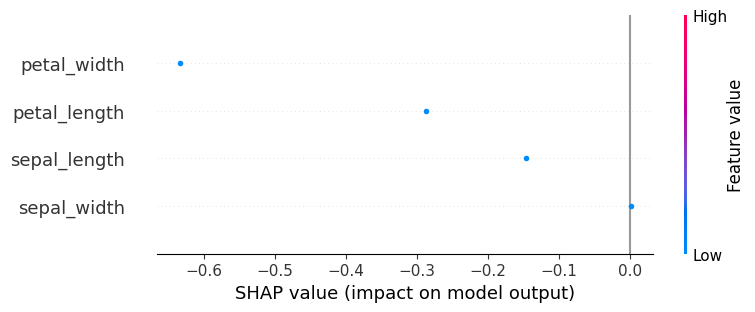

In [170]:
shap.plots.beeswarm(shap_values)

In [171]:
shap_values[0]

.values =
array([-0.14619237,  0.00139422, -0.2868198 , -0.63380821])

.base_values =
-0.4780758415519859

.data =
array([4.30000019, 3.        , 1.10000002, 0.1       ])

In [122]:
shap_values[1]

.values =
array([-0.14619237,  0.00139422, -0.2868198 , -0.63380821])

.base_values =
-0.4780758415519859

.data =
array([4.4000001 , 3.        , 1.29999995, 0.2       ])

In [130]:
THRESHOLD = 0.5


def shap_udf(row): #work on a single spark dataframe row, for all rows. This work is distributed among all the worker nodes of your Apache Spark cluster.
    dict = {}
    pos_features = []
    neg_features = []

    columns = list(row.asDict())
    for feature in columns:
        dict[feature] = row[feature]
    
    dict_importance = {key: value for key, value in sorted(dict.items(), key=lambda item: __builtin__.abs(item[1]), reverse = True)}
    
    for k,v in dict_importance.items():
        if __builtin__.abs(v) >= THRESHOLD:
            if v > 0:
                pos_features.append((k,v))
            else:
                neg_features.append((k,v))
    
    features = []
    #taking top 5 features from pos and neg features. We can increase this number.
    features.append(pos_features[:5])
    features.append(neg_features[:5])
    
    return features


udf_obj = F.udf(shap_udf, ArrayType(ArrayType(StructType([
  StructField('Feature', StringType()),
  StructField('Shap_Value', FloatType()),
]))))

In [131]:
spark_df = transformed_train_data_tree
new_sparkdf = spark_shapdf.withColumn('Shap_Importance', udf_obj(F.struct([spark_shapdf[x] for x in spark_shapdf.columns])))

In [132]:
new_sparkdf.show()

+--------------------+--------------------+-------------------+-------------------+--------------------+
|        sepal_length|         sepal_width|       petal_length|        petal_width|     Shap_Importance|
+--------------------+--------------------+-------------------+-------------------+--------------------+
| -0.1461923748365155|0.001394222556723...|-0.2868197951894507|-0.6338082137037553|[[{sepal_width, 0...|
| -0.1461923748365155|0.001394222556723...|-0.2868197951894507|-0.6338082137037553|[[{sepal_width, 0...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|
| -0.1461923748365155|-0.00278844511344...|-0.290127020

In [133]:
final_sparkdf = new_sparkdf.withColumn('Positive_Shap', new_sparkdf.Shap_Importance[0]).withColumn('Negative_Shap', new_sparkdf.Shap_Importance[1])

In [134]:
final_sparkdf.show()

+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|        sepal_length|         sepal_width|       petal_length|        petal_width|     Shap_Importance|       Positive_Shap|       Negative_Shap|
+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
| -0.1461923748365155|0.001394222556723...|-0.2868197951894507|-0.6338082137037553|[[{sepal_width, 0...|[{sepal_width, 0....|[{petal_width, -0...|
| -0.1461923748365155|0.001394222556723...|-0.2868197951894507|-0.6338082137037553|[[{sepal_width, 0...|[{sepal_width, 0....|[{petal_width, -0...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|                  []|[{petal_width, -0...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|              

In [135]:
shap_values[0].data.shape

(4,)

In [136]:
shap_values[0].data

array([4.30000019, 3.        , 1.10000002, 0.1       ])

In [137]:
shap_values[1].data

array([4.4000001 , 3.        , 1.29999995, 0.2       ])

In [138]:
final_sparkdf.toPandas()

,sepal_length,sepal_width,petal_length,petal_width,Shap_Importance,Positive_Shap,Negative_Shap
0,-0.146192,0.001394,-0.286820,-0.633808,"[[(sepal_width, 0.0013942226069048047)], [(pet...","[(sepal_width, 0.0013942226069048047)]","[(petal_width, -0.6338081955909729), (petal_le..."
1,-0.146192,0.001394,-0.286820,-0.633808,"[[(sepal_width, 0.0013942226069048047)], [(pet...","[(sepal_width, 0.0013942226069048047)]","[(petal_width, -0.6338081955909729), (petal_le..."
2,-0.146192,-0.002788,-0.290127,-0.626318,"[[], [(petal_width, -0.6263183355331421), (pet...",[],"[(petal_width, -0.6263183355331421), (petal_le..."
3,-0.146192,-0.002788,-0.290127,-0.626318,"[[], [(petal_width, -0.6263183355331421), (pet...",[],"[(petal_width, -0.6263183355331421), (petal_le..."
4,-0.146192,-0.002788,-0.290127,-0.626318,"[[], [(petal_width, -0.6263183355331421), (pet...",[],"[(petal_width, -0.6263183355331421), (petal_le..."
...,...,...,...,...,...,...,...
108,0.130277,0.000492,0.777309,1.113500,"[[(petal_width, 1.1135003566741943), (petal_le...","[(petal_width, 1.1135003566741943), (petal_len...",[]
109,0.130277,0.000492,0.777309,1.113500,"[[(petal_width, 1.1135003566741943), (petal_le...","[(petal_width, 1.1135003566741943), (petal_len...",[]
110,0.130277,0.000492,0.777309,1.113500,"[[(petal_width, 1.1135003566741943), (petal_le...","[(petal_width, 1.1135003566741943), (petal_len...",[]
111,0.130277,-0.000983,0.779383,1.112901,"[[(petal_width, 1.112900972366333), (petal_len...","[(petal_width, 1.112900972366333), (petal_leng...","[(sepal_width, -0.000983229256235063)]"


In [159]:
pd.DataFrame(list(spark_df.select("features").take(1)[0]), columns=assembler_tree.getInputCols())

,sepal_length,sepal_width,petal_length,petal_width
0,4.3,3.0,1.1,0.1


In [ ]:
list(spark_df.select("features").take(1)[0][0])

In [146]:
explainer.shap_values(pd.DataFrame(spark_df.select("features").take(1)), check_additivity = False)

ValueError: could not convert string to float: 'setosa'

In [167]:
shap_values

.values =
array([[-1.46192375e-01,  1.39422256e-03, -2.86819795e-01,
        -6.33808214e-01],
       [-1.46192375e-01,  1.39422256e-03, -2.86819795e-01,
        -6.33808214e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-01,
        -6.26318320e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-01,
        -6.26318320e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-01,
        -6.26318320e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-01,
        -6.26318320e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-01,
        -6.26318320e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-01,
        -6.26318320e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-01,
        -6.26318320e-01],
       [-1.46192375e-01,  1.39422256e-03, -2.86819795e-01,
        -6.33808214e-01],
       [-1.46192375e-01,  1.39422256e-03, -2.86819795e-01,
        -6.33808214e-01],
       [-1.46192375e-01, -2.78844511e-03, -2.90127021e-

In [163]:
# SHAP計算用のUDFを定義
def calculate_shap_udf(row):
    row_df = pd.DataFrame(row.select("features")[0], columns=assembler_tree.getInputCols())
    explainer = shap.TreeExplainer(gbt)
    shap_values = explainer.shap_values(row_df, check_additivity = False)
    return shap_values

schema = ArrayType(ArrayType(StructType([
    StructField('Feature', StringType()),
    StructField('Shap_Value', FloatType()),
])))

shap_udf = F.udf(calculate_shap_udf, schema)

In [164]:
new_sparkdf = spark_df.withColumn('Shap_Importance', shap_udf(F.struct([spark_df[x] for x in spark_df.columns])))

Traceback (most recent call last):
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/Users/thama/ghq/github.com/mathmathpp2/synapselightgbm_trial/synapse-test/.venv/lib/python3.11/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
TypeError: cannot pickle '_thread.RLock' object


PicklingError: Could not serialize object: TypeError: cannot pickle '_thread.RLock' object

In [162]:
final_sparkdf = new_sparkdf.withColumn('Positive_Shap', new_sparkdf.Shap_Importance[0]).withColumn('Negative_Shap', new_sparkdf.Shap_Importance[1])

final_sparkdf.show()


+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
|        sepal_length|         sepal_width|       petal_length|        petal_width|     Shap_Importance|       Positive_Shap|       Negative_Shap|
+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+
| -0.1461923748365155|0.001394222556723...|-0.2868197951894507|-0.6338082137037553|[[{sepal_width, 0...|[{sepal_width, 0....|[{petal_width, -0...|
| -0.1461923748365155|0.001394222556723...|-0.2868197951894507|-0.6338082137037553|[[{sepal_width, 0...|[{sepal_width, 0....|[{petal_width, -0...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|                  []|[{petal_width, -0...|
| -0.1461923748365155|-0.00278844511344...|-0.2901270207891203|-0.6263183204339151|[[], [{petal_widt...|              